<a href="https://colab.research.google.com/github/GarlandZhang/hairy_gan/blob/master/hairy_gan.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import files
import os

import pandas as pd
import os
import shutil
if not os.path.exists('kaggle.json'):
  shutil.copy('/content/drive/My Drive/hairy_gan/kaggle.json', 'kaggle.json')
  # !pip install -q kaggle
  # files.upload()
  !mkdir -p ~/.kaggle
  !cp kaggle.json ~/.kaggle/
  !kaggle datasets download -d jessicali9530/celeba-dataset --force
  !unzip celeba-dataset.zip
  !mv img_align_celeba celeba-dataset
  !mv list_eval_partition.csv celeba-dataset/list_eval_partition.csv
  !mv list_landmarks_align_celeba.csv celeba-dataset/list_landmarks_align_celeba.csv
  !mv list_attr_celeba.csv celeba-dataset/list_attr_celeba.csv
  !mv list_bbox_celeba.csv celeba-dataset/list_bbox_celeba.csv

  !mkdir celeba-dataset/trainA
  !mkdir celeba-dataset/trainB
  !mkdir celeba-dataset/validationA
  !mkdir celeba-dataset/validationB
  !mkdir celeba-dataset/testA
  !mkdir celeba-dataset/testB

  complete_df = pd.read_csv('celeba-dataset/list_attr_celeba.csv')
  partitions_df = pd.read_csv('celeba-dataset/list_eval_partition.csv') # 0 => train, 1 => validation, 2 => test
  for i, set_name in enumerate(['train', 'validation', 'test']):
    set_ids_df = partitions_df.loc[partitions_df['partition'] == i]['image_id']
    complete_df[complete_df['image_id'].isin(set_ids_df.tolist())]
    non_blond_hair_ids = complete_df.loc[complete_df['Blond_Hair'] != 1]['image_id'].tolist() # filters out black hair candidates
    blond_hair_ids = complete_df.loc[complete_df['Blond_Hair'] == 1]['image_id'].tolist() # filters out blond hair candidates
    for id in non_blond_hair_ids:
      shutil.copy(os.path.join('celeba-dataset/img_align_celeba', id), os.path.join('celeba-dataset', f'{set_name}A', id))

    for id in blond_hair_ids:
      shutil.copy(os.path.join('celeba-dataset/img_align_celeba', id), os.path.join('celeba-dataset', f'{set_name}B', id))  

  !git clone https://www.github.com/keras-team/keras-contrib.git \
    && cd keras-contrib \
    && pip install git+https://www.github.com/keras-team/keras-contrib.git \
    && python convert_to_tf_keras.py \
    && USE_TF_KERAS=1 python setup.py install

  !pip install scipy==1.1.0

Streaming output truncated to the last 5000 lines.
  inflating: img_align_celeba/img_align_celeba/197910.jpg  
  inflating: img_align_celeba/img_align_celeba/197911.jpg  
  inflating: img_align_celeba/img_align_celeba/197912.jpg  
  inflating: img_align_celeba/img_align_celeba/197913.jpg  
  inflating: img_align_celeba/img_align_celeba/197914.jpg  
  inflating: img_align_celeba/img_align_celeba/197915.jpg  
  inflating: img_align_celeba/img_align_celeba/197916.jpg  
  inflating: img_align_celeba/img_align_celeba/197917.jpg  
  inflating: img_align_celeba/img_align_celeba/197918.jpg  
  inflating: img_align_celeba/img_align_celeba/197919.jpg  
  inflating: img_align_celeba/img_align_celeba/197920.jpg  
  inflating: img_align_celeba/img_align_celeba/197921.jpg  
  inflating: img_align_celeba/img_align_celeba/197922.jpg  
  inflating: img_align_celeba/img_align_celeba/197923.jpg  
  inflating: img_align_celeba/img_align_celeba/197924.jpg  
  inflating: img_align_celeba/img_align_celeba/19

In [15]:
from __future__ import print_function, division
import scipy
from keras.datasets import mnist
from keras.models import Model, Sequential
from keras_contrib.layers.normalization.instancenormalization import InstanceNormalization
from keras.layers import Input, Dense, Reshape, Flatten, Dropout, Concatenate
from keras.layers import BatchNormalization, Activation, ZeroPadding2D
from keras.layers import LeakyReLU
from keras.layers.convolutional import UpSampling2D, Conv2D
from keras.optimizers import Adam
from keras.models import load_model

import datetime
import matplotlib.pyplot as plt
import sys
import numpy as np
import os
from glob import glob
from PIL import Image

import tensorflow as tf
from tensorflow.python.keras.backend import set_session
# from tensorflow.python.keras.models import load_model
tf.compat.v1.enable_eager_execution()
# tf.compat.v1.disable_eager_execution()

from tqdm import tqdm

In [3]:
class DataLoader():
    def __init__(self, dataset_name, img_res):
        self.dataset_name = dataset_name
        self.img_res = img_res

    def load_data(self, domain, batch_size=1, is_testing=False):
        data_type = "train%s" % domain if not is_testing else "test%s" % domain
        path = glob('%s/%s/*' % (self.dataset_name, data_type))

        batch_images = np.random.choice(path, size=batch_size)

        imgs = []
        for img_path in batch_images:
            img = self.imread(img_path)
            if not is_testing:
                img = scipy.misc.imresize(img, self.img_res)

                if np.random.random() > 0.5:
                    img = np.fliplr(img)
            else:
                img = scipy.misc.imresize(img, self.img_res)
            imgs.append(img)

        imgs = np.array(imgs)/127.5 - 1.

        return imgs

    def load_batch(self, batch_size=1, is_testing=False):
        data_type = "train" if not is_testing else "val"
        path_A = glob('%s/%sA/*' % (self.dataset_name, data_type))
        path_B = glob('%s/%sB/*' % (self.dataset_name, data_type))

        self.n_batches = int(min(len(path_A), len(path_B)) / batch_size)
        total_samples = self.n_batches * batch_size

        # Sample n_batches * batch_size from each path list so that model sees all
        # samples from both domains
        path_A = np.random.choice(path_A, total_samples, replace=False)
        path_B = np.random.choice(path_B, total_samples, replace=False)

        for i in range(self.n_batches-1):
            batch_A = path_A[i*batch_size:(i+1)*batch_size]
            batch_B = path_B[i*batch_size:(i+1)*batch_size]
            imgs_A, imgs_B = [], []
            for img_A, img_B in zip(batch_A, batch_B):
                img_A = self.imread(img_A)
                img_B = self.imread(img_B)

                img_A = scipy.misc.imresize(img_A, self.img_res)
                img_B = scipy.misc.imresize(img_B, self.img_res)

                if not is_testing and np.random.random() > 0.5:
                        img_A = np.fliplr(img_A)
                        img_B = np.fliplr(img_B)

                imgs_A.append(img_A)
                imgs_B.append(img_B)

            imgs_A = np.array(imgs_A)/127.5 - 1.
            imgs_B = np.array(imgs_B)/127.5 - 1.

            yield imgs_A, imgs_B

    def imread(self, path):
        return scipy.misc.imread(path, mode='RGB').astype(np.float)

In [37]:
class HairyGan(): # based on CycleGan
  def __init__(self):
    
    # self.sess = tf.compat.v1.Session()
    # set_session(self.sess)
    
    # self.graph = tf.compat.v1.get_default_graph()
    
    # self.graph = tf.Graph()
    # self.graph2 = tf.Graph()

    self.img_rows = 128
    self.img_cols = 128
    self.img_channels = 3

    self.img_shape = (self.img_rows, self.img_cols, self.img_channels)
    
    patch = int(self.img_rows / 2**4)
    self.disc_out = (patch, patch, 1) # output shape of discriminator

    self.data_loader = DataLoader(dataset_name='celeba-dataset', img_res=(self.img_rows, self.img_cols))

    self.optimizer = Adam(0.0002, 0.5)

  def build_combined(self):
    lambda_cycle = 10.
    lambda_id = 0.9 * lambda_cycle

    img_A = Input(shape=self.img_shape) # image from domain A
    img_B = Input(shape=self.img_shape) # image from domain B

    fake_A = self.g_BA(img_B)
    fake_B = self.g_AB(img_A)
    
    reconstr_A = self.g_BA(fake_B)
    reconstr_B = self.g_AB(fake_A)

    id_A = self.g_BA(img_A)
    id_B = self.g_AB(img_B)


    self.d_A.trainable = False
    self.d_B.trainable = False

    valid_A = self.d_A(fake_A)
    valid_B = self.d_B(fake_B)

    combined = Model(
        inputs=[img_A, img_B],
        outputs=[valid_A, valid_B, reconstr_A, reconstr_B, id_A, id_B]
    )

    combined.compile(
        loss=['mse', 'mse', 'mae', 'mae', 'mae', 'mae'],
        loss_weights=[1, 1, lambda_cycle, lambda_cycle, lambda_id, lambda_id],
        optimizer=self.optimizer
    )

    return combined

  def build_discriminator(self):

    def d_conv_block(layer_input, num_filt, f_size=4, normalization=True):
      d = Conv2D(num_filt, kernel_size=f_size, strides=2, padding='same')(layer_input)
      d = LeakyReLU(alpha=0.2)(d)
      if normalization:
        d = InstanceNormalization()(d)

      return d

    num_filt = 64

    img = Input(shape=self.img_shape)
    d1 = d_conv_block(img, num_filt, normalization=False)
    d2 = d_conv_block(d1, num_filt * 2)
    d3 = d_conv_block(d2, num_filt * 4)
    d4 = d_conv_block(d3, num_filt * 8)
    output = Conv2D(1, kernel_size=4, strides=1, padding='same')(d4)

    return Model(img, output)

  def build_generator(self):
    def g_conv_block(layer_input, num_filt, f_size=4):
      d = Conv2D(num_filt, kernel_size=f_size, strides=2, padding='same')(layer_input)
      d = LeakyReLU(alpha=0.2)(d)
      d = InstanceNormalization()(d)
      return d

    def g_deconv_block(layer_input, skip_input, num_filt, f_size=4, dropout_rate=0):
      u = UpSampling2D(size=2)(layer_input)
      u = Conv2D(num_filt, kernel_size=f_size, strides=1, padding='same', activation='relu')(u)
      
      if dropout_rate:
        u = Dropout(dropout_rate)(u)
      
      u = InstanceNormalization()(u)
      u = Concatenate()([u, skip_input])

      return u

    num_filt = 32

    d0 = Input(shape=self.img_shape)
    d1 = g_conv_block(d0, num_filt)
    d2 = g_conv_block(d1, num_filt * 2)
    d3 = g_conv_block(d2, num_filt * 4)
    d4 = g_conv_block(d3, num_filt * 8)

    u1 = g_deconv_block(d4, d3, num_filt * 4)
    u2 = g_deconv_block(u1, d2, num_filt * 2)
    u3 = g_deconv_block(u2, d1, num_filt)

    u4 = UpSampling2D(size=2)(u3)
    output = Conv2D(self.img_channels, kernel_size=4, strides=1, padding='same', activation='tanh')(u4)

    return Model(d0, output)

  def train_fake(self, epochs, batch_size=1, sample_interval=50):

    # with self.graph.as_default():
    # discriminators
    self.d_A = self.build_discriminator()
    self.d_B = self.build_discriminator()

    self.d_A.compile(loss='mse', optimizer=self.optimizer, metrics=['accuracy'])
    self.d_B.compile(loss='mse', optimizer=self.optimizer, metrics=['accuracy'])

    # generators
    self.g_AB = self.build_generator()
    self.g_BA = self.build_generator()

    self.combined_model = self.build_combined()


    d_out_shape = (batch_size, ) + self.disc_out

    valid = np.ones(d_out_shape)
    fake = np.zeros(d_out_shape)

    # with self.graph.as_default():
      # set_session(self.sess)
    for epoch in range(epochs):
      batch_gen = self.data_loader.load_batch(batch_size)
      for i, elem in enumerate(batch_gen):
        break# hack to run function once

      steps_per_epoch = self.data_loader.n_batches - 2
      for step in tqdm(range(steps_per_epoch), desc=f'Train {epoch} / {epochs}', total=steps_per_epoch):
        batch_i = step

        imgs_A, imgs_B = next(batch_gen)

        fake_A = self.g_BA.predict(imgs_B)
        fake_B = self.g_AB.predict(imgs_A)

        real_A_history = self.d_A.fit(imgs_A, valid, batch_size=batch_size)
        fake_A_history = self.d_A.fit(fake_A, fake, batch_size=batch_size)
        # d_A_loss = 0.5 * np.add(real_A_loss, fake_A_loss)

        real_B_history = self.d_B.fit(imgs_B, valid, batch_size=batch_size)
        fake_B_history = self.d_B.fit(fake_B, fake, batch_size=batch_size)
        # d_B_loss = 0.5 * np.add(real_B_loss, fake_B_loss)

        # d_loss = 0.5 * np.add(d_A_loss, d_B_loss)

        g_history = self.combined_model.fit(
            [imgs_A, imgs_B],
            [fake, fake, imgs_A, imgs_B, imgs_A, imgs_B],
            batch_size=batch_size
        )

        if (batch_i + 1) % sample_interval == 0:
          self.sample_images(epoch, batch_i)
          project_path = '/content/drive/My Drive/hairy_gan'
          self.d_A.save('d_A.hdf5')
          shutil.copy('d_A.hdf5', os.path.join(project_path, 'd_A.hdf5'))

          self.d_B.save('d_B.hdf5')
          shutil.copy('d_B.hdf5', os.path.join(project_path, 'd_B.hdf5'))


          self.g_AB.save('g_AB.hdf5')
          shutil.copy('g_AB.hdf5', os.path.join(project_path, 'g_AB.hdf5'))

          self.g_BA.save('g_BA.hdf5')
          shutil.copy('g_BA.hdf5', os.path.join(project_path, 'g_BA.hdf5'))

  def train(self, epochs, batch_size=1, sample_interval=50):
    d_out_shape = (batch_size, ) + gan.disc_out

    valid = np.ones(d_out_shape)

    # sess = tf.compat.v1.Session()

    # with self.graph.as_default():
    # self.d_A = self.build_discriminator()
    # self.d_A.compile(loss='mse', optimizer=Adam(), metrics=['accuracy'])
    

    # # with self.graph2.as_default():
    # self.d_B = self.build_discriminator()
    # self.d_B.compile(loss='mse', optimizer=Adam(), metrics=['accuracy'])

    # # generators
    # self.g_AB = self.build_generator()
    # self.g_BA = self.build_generator()

    # self.combined_model = self.build_combined()
    
    if os.path.exists(os.path.join(project_path, 'd_A.hdf5')):
      self.d_A = load_model(os.path.join(project_path, 'd_A.hdf5'), custom_objects={'InstanceNormalization': InstanceNormalization})
    else:
      self.d_A = self.build_discriminator()
      self.d_A.compile(loss='mse', optimizer=self.optimizer, metrics=['accuracy'])

    if os.path.exists(os.path.join(project_path, 'd_B.hdf5')):
      self.d_B = load_model(os.path.join(project_path, 'd_B.hdf5'), custom_objects={'InstanceNormalization': InstanceNormalization})
    else:
      self.d_B = self.build_discriminator()
      self.d_B.compile(loss='mse', optimizer=self.optimizer, metrics=['accuracy'])

    if os.path.exists(os.path.join(project_path, 'g_AB.hdf5')):
      self.g_AB = load_model(os.path.join(project_path, 'g_AB.hdf5'), custom_objects={'InstanceNormalization': InstanceNormalization})
    else:
      self.g_AB = self.build_generator()

    if os.path.exists(os.path.join(project_path, 'g_BA.hdf5')):
      self.g_BA = load_model(os.path.join(project_path, 'g_BA.hdf5'), custom_objects={'InstanceNormalization': InstanceNormalization})
    else:
      self.g_BA = self.build_generator()

    self.combined_model = self.build_combined()


    d_out_shape = (batch_size, ) + self.disc_out

    valid = np.ones(d_out_shape)
    fake = np.zeros(d_out_shape)

    batch_gen = self.data_loader.load_batch(batch_size)
    for epoch in range(epochs):
      batch_gen = self.data_loader.load_batch(batch_size)
      for i, elem in enumerate(batch_gen):
        break# hack to run function once

      steps_per_epoch = self.data_loader.n_batches - 2
      for step in tqdm(range(steps_per_epoch), desc=f'Train {epoch} / {epochs}', total=steps_per_epoch):
        batch_i = step

        imgs_A, imgs_B = next(batch_gen)

        fake_A = self.g_BA.predict(imgs_B)
        fake_B = self.g_AB.predict(imgs_A)

        real_A_history = self.d_A.fit(imgs_A, valid, batch_size=batch_size)
        fake_A_history = self.d_A.fit(fake_A, fake, batch_size=batch_size)
        # d_A_loss = 0.5 * np.add(real_A_loss, fake_A_loss)

        real_B_history = self.d_B.fit(imgs_B, valid, batch_size=batch_size)
        fake_B_history = self.d_B.fit(fake_B, fake, batch_size=batch_size)
        # d_B_loss = 0.5 * np.add(real_B_loss, fake_B_loss)

        # d_loss = 0.5 * np.add(d_A_loss, d_B_loss)

        g_history = self.combined_model.fit(
            [imgs_A, imgs_B],
            [fake, fake, imgs_A, imgs_B, imgs_A, imgs_B],
            batch_size=batch_size
        )

        if (batch_i + 1) % sample_interval == 0:
          self.sample_images(epoch, batch_i)
          
          self.d_A.save('d_A.hdf5')
          shutil.copy('d_A.hdf5', os.path.join(project_path, 'd_A.hdf5'))

          self.d_B.save('d_B.hdf5')
          shutil.copy('d_B.hdf5', os.path.join(project_path, 'd_B.hdf5'))


          self.g_AB.save('g_AB.hdf5')
          shutil.copy('g_AB.hdf5', os.path.join(project_path, 'g_AB.hdf5'))

          self.g_BA.save('g_BA.hdf5')
          shutil.copy('g_BA.hdf5', os.path.join(project_path, 'g_BA.hdf5'))

  def sample_images(self, epoch, batch_i):
    print(f'Epoch: {epoch} with batch: {batch_i}')
    rows, cols = 2, 3

    imgs_A = self.data_loader.load_data(domain='A', batch_size=1, is_testing=True)
    imgs_B = self.data_loader.load_data(domain='B', batch_size=1, is_testing=True)

    fake_A = self.g_BA.predict(imgs_B)
    fake_B = self.g_AB.predict(imgs_A)

    reconstr_A = self.g_BA.predict(fake_B)
    reconstr_B = self.g_AB.predict(fake_A)

    gen_imgs = np.concatenate([imgs_A, fake_B, reconstr_A, imgs_B, fake_A, reconstr_B])

    gen_imgs = 0.5 * gen_imgs + 0.5

    titles = ['Original', 'Translated', 'Reconstructed']
    fig, axes = plt.subplots(rows, cols)

    count = 0

    for i in range(rows):
      for j in range(cols):
        axes[i, j].imshow(gen_imgs[count])
        axes[i, j].set_title(titles[j])
        axes[i, j].axis('off')
        count += 1

    plt.show()
    

/usr/local/lib/python3.6/dist-packages/keras/engine/saving.py:384: UserWarning: Error in loading the saved optimizer state. As a result, your model is starting with a freshly initialized optimizer.
  warnings.warn('Error in loading the saved optimizer '
/usr/local/lib/python3.6/dist-packages/keras/engine/saving.py:341: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:65: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:50: Depre

Epoch 1/1
2/2 [==============================] - 0s 206ms/step - loss: 46.6904 - accuracy: 0.0234
Epoch 1/1
2/2 [==============================] - 0s 10ms/step - loss: 19.5950 - accuracy: 0.1016
Epoch 1/1
2/2 [==============================] - 0s 224ms/step - loss: 31.0472 - accuracy: 0.0156
Epoch 1/1
2/2 [==============================] - 0s 10ms/step - loss: 4.6680 - accuracy: 0.1953
Epoch 1/1
2/2 [==============================] - 5s 3s/step - loss: 55.8748 - model_38_loss: 1.4581 - model_39_loss: 25.6731 - model_41_loss: 0.8830 - model_40_loss: 0.7608
Epoch: 0 with batch: 0


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:21: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.


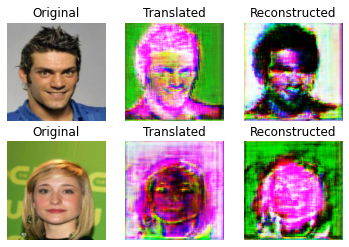





Train 0 / 2:   0%|          | 1/14989 [00:21<90:51:37, 21.82s/it]

Epoch 1/1
2/2 [==============================] - 0s 10ms/step - loss: 1.0270 - accuracy: 0.4141
Epoch 1/1
2/2 [==============================] - 0s 10ms/step - loss: 5.7349 - accuracy: 0.1250
Epoch 1/1
2/2 [==============================] - 0s 12ms/step - loss: 7.4959 - accuracy: 0.1328
Epoch 1/1
2/2 [==============================] - 0s 9ms/step - loss: 2.5171 - accuracy: 0.2266
Epoch 1/1
2/2 [==============================] - 0s 102ms/step - loss: 36.7663 - model_38_loss: 1.0154 - model_39_loss: 15.0883 - model_41_loss: 0.4459 - model_40_loss: 0.6803
Epoch: 0 with batch: 1


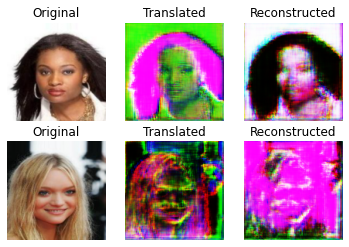





Train 0 / 2:   0%|          | 2/14989 [00:25<68:11:50, 16.38s/it]

Epoch 1/1
2/2 [==============================] - 0s 11ms/step - loss: 1.5419 - accuracy: 0.2578
Epoch 1/1
2/2 [==============================] - 0s 11ms/step - loss: 1.0091 - accuracy: 0.4219
Epoch 1/1
2/2 [==============================] - 0s 11ms/step - loss: 16.2644 - accuracy: 0.0938
Epoch 1/1
2/2 [==============================] - 0s 10ms/step - loss: 0.2617 - accuracy: 0.6719
Epoch 1/1
2/2 [==============================] - 0s 112ms/step - loss: 21.6764 - model_38_loss: 0.3910 - model_39_loss: 1.1940 - model_41_loss: 0.3428 - model_40_loss: 0.6874
Epoch: 0 with batch: 2


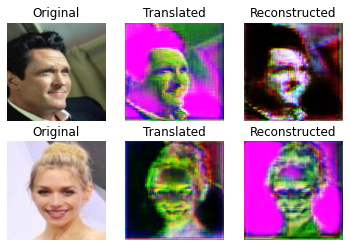





Train 0 / 2:   0%|          | 3/14989 [00:29<53:15:19, 12.79s/it]

Epoch 1/1
2/2 [==============================] - 0s 9ms/step - loss: 2.5512 - accuracy: 0.1172
Epoch 1/1
2/2 [==============================] - 0s 10ms/step - loss: 3.4350 - accuracy: 0.1641
Epoch 1/1
2/2 [==============================] - 0s 10ms/step - loss: 2.2793 - accuracy: 0.1172
Epoch 1/1
2/2 [==============================] - 0s 10ms/step - loss: 0.3653 - accuracy: 0.5469
Epoch 1/1
2/2 [==============================] - 0s 102ms/step - loss: 21.2496 - model_38_loss: 0.6918 - model_39_loss: 0.4299 - model_41_loss: 0.5827 - model_40_loss: 0.5011
Epoch: 0 with batch: 3


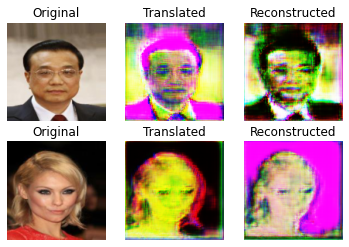





Train 0 / 2:   0%|          | 4/14989 [00:34<42:38:54, 10.25s/it]

Epoch 1/1
2/2 [==============================] - 0s 9ms/step - loss: 3.7990 - accuracy: 0.0703
Epoch 1/1
2/2 [==============================] - 0s 9ms/step - loss: 0.5984 - accuracy: 0.4609
Epoch 1/1
2/2 [==============================] - 0s 9ms/step - loss: 0.2541 - accuracy: 0.6797
Epoch 1/1
2/2 [==============================] - 0s 9ms/step - loss: 1.0070 - accuracy: 0.2500
Epoch 1/1
2/2 [==============================] - 0s 95ms/step - loss: 18.2728 - model_38_loss: 0.8322 - model_39_loss: 0.1628 - model_41_loss: 0.4231 - model_40_loss: 0.4773
Epoch: 0 with batch: 4


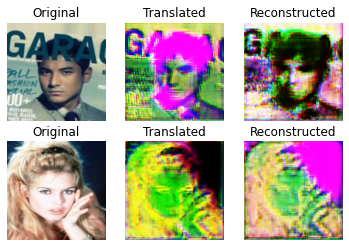





Train 0 / 2:   0%|          | 5/14989 [00:37<34:30:23,  8.29s/it]

Epoch 1/1
2/2 [==============================] - 0s 8ms/step - loss: 0.8820 - accuracy: 0.3125
Epoch 1/1
2/2 [==============================] - 0s 8ms/step - loss: 0.5618 - accuracy: 0.5078
Epoch 1/1
2/2 [==============================] - 0s 9ms/step - loss: 0.8790 - accuracy: 0.2891
Epoch 1/1
2/2 [==============================] - 0s 8ms/step - loss: 0.1329 - accuracy: 0.8281
Epoch 1/1
2/2 [==============================] - 0s 89ms/step - loss: 19.0962 - model_38_loss: 0.6566 - model_39_loss: 0.1185 - model_41_loss: 0.5204 - model_40_loss: 0.4524
Epoch: 0 with batch: 5


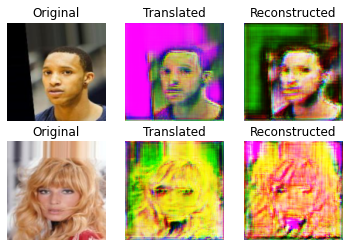





Train 0 / 2:   0%|          | 6/14989 [00:42<29:35:45,  7.11s/it]

Epoch 1/1
2/2 [==============================] - 0s 9ms/step - loss: 0.4362 - accuracy: 0.6094
Epoch 1/1
2/2 [==============================] - 0s 8ms/step - loss: 1.1579 - accuracy: 0.2891
Epoch 1/1
2/2 [==============================] - 0s 8ms/step - loss: 0.4369 - accuracy: 0.4609
Epoch 1/1
2/2 [==============================] - 0s 8ms/step - loss: 1.0029 - accuracy: 0.3906
Epoch 1/1
2/2 [==============================] - 0s 82ms/step - loss: 19.0019 - model_38_loss: 0.3673 - model_39_loss: 0.2820 - model_41_loss: 0.5295 - model_40_loss: 0.5042
Epoch: 0 with batch: 6


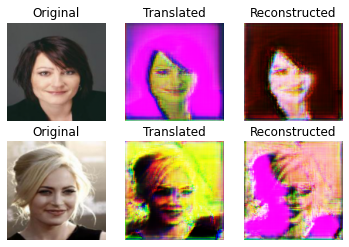





Train 0 / 2:   0%|          | 7/14989 [00:46<26:05:03,  6.27s/it]

Epoch 1/1
2/2 [==============================] - 0s 8ms/step - loss: 0.6540 - accuracy: 0.1797
Epoch 1/1
2/2 [==============================] - 0s 9ms/step - loss: 0.3580 - accuracy: 0.5938
Epoch 1/1
2/2 [==============================] - 0s 8ms/step - loss: 4.9968 - accuracy: 0.1562
Epoch 1/1
2/2 [==============================] - 0s 8ms/step - loss: 0.5559 - accuracy: 0.2578
Epoch 1/1
2/2 [==============================] - 0s 81ms/step - loss: 15.2580 - model_38_loss: 0.2138 - model_39_loss: 0.1908 - model_41_loss: 0.2342 - model_40_loss: 0.5588
Epoch: 0 with batch: 7


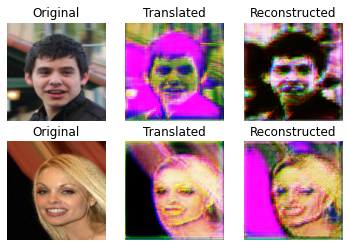





Train 0 / 2:   0%|          | 8/14989 [00:51<23:46:16,  5.71s/it]

Epoch 1/1
2/2 [==============================] - 0s 10ms/step - loss: 0.5923 - accuracy: 0.3750
Epoch 1/1
2/2 [==============================] - 0s 8ms/step - loss: 1.6301 - accuracy: 0.2891
Epoch 1/1
2/2 [==============================] - 0s 10ms/step - loss: 2.4753 - accuracy: 0.2656
Epoch 1/1
2/2 [==============================] - 0s 8ms/step - loss: 0.3315 - accuracy: 0.6406
Epoch 1/1
2/2 [==============================] - 0s 81ms/step - loss: 18.2964 - model_38_loss: 2.4822 - model_39_loss: 0.1758 - model_41_loss: 0.3499 - model_40_loss: 0.4529
Epoch: 0 with batch: 8


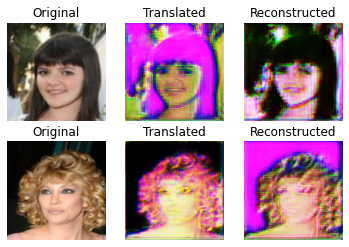





Train 0 / 2:   0%|          | 9/14989 [00:55<22:01:05,  5.29s/it]

Epoch 1/1
2/2 [==============================] - 0s 8ms/step - loss: 0.5871 - accuracy: 0.5234
Epoch 1/1
2/2 [==============================] - 0s 8ms/step - loss: 1.4116 - accuracy: 0.3516
Epoch 1/1
2/2 [==============================] - 0s 8ms/step - loss: 1.3341 - accuracy: 0.2812
Epoch 1/1
2/2 [==============================] - 0s 9ms/step - loss: 0.8645 - accuracy: 0.1641
Epoch 1/1
2/2 [==============================] - 0s 81ms/step - loss: 17.4273 - model_38_loss: 0.3124 - model_39_loss: 0.1491 - model_41_loss: 0.4173 - model_40_loss: 0.5549
Epoch: 0 with batch: 9


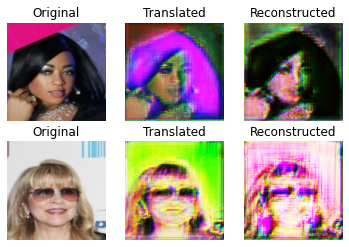





Train 0 / 2:   0%|          | 10/14989 [00:59<20:54:52,  5.03s/it]

Epoch 1/1
2/2 [==============================] - 0s 8ms/step - loss: 1.5569 - accuracy: 0.1016
Epoch 1/1
2/2 [==============================] - 0s 8ms/step - loss: 0.3507 - accuracy: 0.6172
Epoch 1/1
2/2 [==============================] - 0s 8ms/step - loss: 0.6267 - accuracy: 0.4766
Epoch 1/1
2/2 [==============================] - 0s 8ms/step - loss: 0.4318 - accuracy: 0.5234
Epoch 1/1
2/2 [==============================] - 0s 82ms/step - loss: 15.7904 - model_38_loss: 0.2997 - model_39_loss: 0.2532 - model_41_loss: 0.2735 - model_40_loss: 0.4861
Epoch: 0 with batch: 10


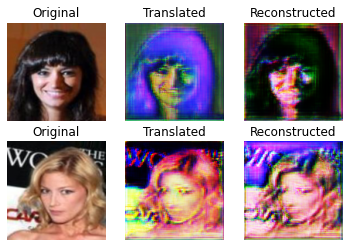





Train 0 / 2:   0%|          | 11/14989 [01:04<20:04:50,  4.83s/it]

Epoch 1/1
2/2 [==============================] - 0s 8ms/step - loss: 0.7912 - accuracy: 0.2891
Epoch 1/1
2/2 [==============================] - 0s 8ms/step - loss: 0.8184 - accuracy: 0.4375
Epoch 1/1
2/2 [==============================] - 0s 8ms/step - loss: 0.8722 - accuracy: 0.4141
Epoch 1/1
2/2 [==============================] - 0s 8ms/step - loss: 0.6422 - accuracy: 0.5391
Epoch 1/1
2/2 [==============================] - 0s 82ms/step - loss: 14.9135 - model_38_loss: 0.1628 - model_39_loss: 0.4308 - model_41_loss: 0.2935 - model_40_loss: 0.4522
Epoch: 0 with batch: 11


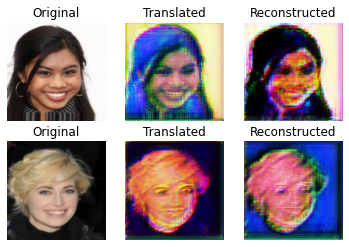





Train 0 / 2:   0%|          | 12/14989 [01:08<19:27:37,  4.68s/it]

Epoch 1/1
2/2 [==============================] - 0s 8ms/step - loss: 0.5485 - accuracy: 0.3906
Epoch 1/1
2/2 [==============================] - 0s 8ms/step - loss: 0.8644 - accuracy: 0.4219
Epoch 1/1
2/2 [==============================] - 0s 8ms/step - loss: 0.4182 - accuracy: 0.3750
Epoch 1/1
2/2 [==============================] - 0s 8ms/step - loss: 0.3704 - accuracy: 0.5703
Epoch 1/1
2/2 [==============================] - 0s 82ms/step - loss: 14.2644 - model_38_loss: 1.4012 - model_39_loss: 0.2947 - model_41_loss: 0.2895 - model_40_loss: 0.3255
Epoch: 0 with batch: 12


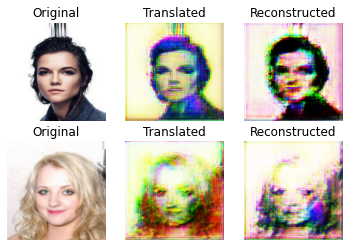





Train 0 / 2:   0%|          | 13/14989 [01:12<19:08:01,  4.60s/it]

Epoch 1/1
2/2 [==============================] - 0s 11ms/step - loss: 0.4291 - accuracy: 0.3516
Epoch 1/1
2/2 [==============================] - 0s 11ms/step - loss: 0.7442 - accuracy: 0.3047
Epoch 1/1
2/2 [==============================] - 0s 11ms/step - loss: 0.1349 - accuracy: 0.7969
Epoch 1/1
2/2 [==============================] - 0s 10ms/step - loss: 1.0368 - accuracy: 0.4062
Epoch 1/1
2/2 [==============================] - 0s 111ms/step - loss: 13.6599 - model_38_loss: 0.2203 - model_39_loss: 2.9370 - model_41_loss: 0.2252 - model_40_loss: 0.2462
Epoch: 0 with batch: 13


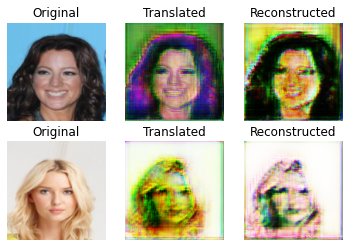





Train 0 / 2:   0%|          | 14/14989 [01:17<18:44:42,  4.51s/it]

Epoch 1/1
2/2 [==============================] - 0s 9ms/step - loss: 0.7563 - accuracy: 0.3047
Epoch 1/1
2/2 [==============================] - 0s 9ms/step - loss: 0.4895 - accuracy: 0.6016
Epoch 1/1
2/2 [==============================] - 0s 10ms/step - loss: 0.1168 - accuracy: 0.8516
Epoch 1/1
2/2 [==============================] - 0s 10ms/step - loss: 0.6602 - accuracy: 0.3281
Epoch 1/1
2/2 [==============================] - 0s 98ms/step - loss: 13.3033 - model_38_loss: 0.1528 - model_39_loss: 0.2164 - model_41_loss: 0.3083 - model_40_loss: 0.3111
Epoch: 0 with batch: 14


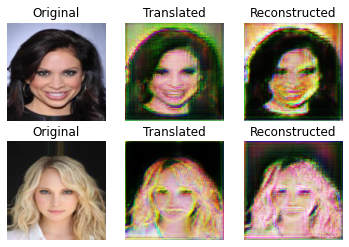





Train 0 / 2:   0%|          | 15/14989 [01:21<18:35:31,  4.47s/it]

Epoch 1/1
2/2 [==============================] - 0s 9ms/step - loss: 0.9969 - accuracy: 0.3750
Epoch 1/1
2/2 [==============================] - 0s 9ms/step - loss: 1.0808 - accuracy: 0.2891
Epoch 1/1
2/2 [==============================] - 0s 9ms/step - loss: 0.4213 - accuracy: 0.4766
Epoch 1/1
2/2 [==============================] - 0s 8ms/step - loss: 0.2370 - accuracy: 0.6250
Epoch 1/1
2/2 [==============================] - 0s 92ms/step - loss: 11.5286 - model_38_loss: 0.3541 - model_39_loss: 0.1285 - model_41_loss: 0.2832 - model_40_loss: 0.2576
Epoch: 0 with batch: 15


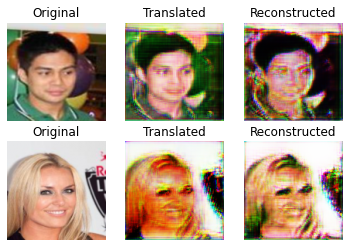





Train 0 / 2:   0%|          | 16/14989 [01:25<18:28:30,  4.44s/it]

Epoch 1/1
2/2 [==============================] - 0s 8ms/step - loss: 0.4062 - accuracy: 0.4609
Epoch 1/1
2/2 [==============================] - 0s 8ms/step - loss: 0.3582 - accuracy: 0.5312
Epoch 1/1
2/2 [==============================] - 0s 8ms/step - loss: 0.7527 - accuracy: 0.2344
Epoch 1/1
2/2 [==============================] - 0s 8ms/step - loss: 0.7526 - accuracy: 0.3516
Epoch 1/1
2/2 [==============================] - 0s 88ms/step - loss: 14.1106 - model_38_loss: 0.0958 - model_39_loss: 2.8562 - model_41_loss: 0.2673 - model_40_loss: 0.3020
Epoch: 0 with batch: 16


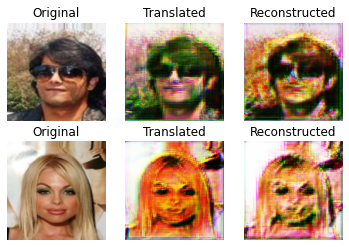





Train 0 / 2:   0%|          | 17/14989 [01:30<18:25:34,  4.43s/it]

Epoch 1/1
2/2 [==============================] - 0s 8ms/step - loss: 0.2227 - accuracy: 0.6562
Epoch 1/1
2/2 [==============================] - 0s 11ms/step - loss: 0.3600 - accuracy: 0.6562
Epoch 1/1
2/2 [==============================] - 0s 11ms/step - loss: 0.4203 - accuracy: 0.5469
Epoch 1/1
2/2 [==============================] - 0s 8ms/step - loss: 0.2736 - accuracy: 0.5000
Epoch 1/1
2/2 [==============================] - 0s 81ms/step - loss: 9.9636 - model_38_loss: 0.2566 - model_39_loss: 0.1911 - model_41_loss: 0.2159 - model_40_loss: 0.2427
Epoch: 0 with batch: 17


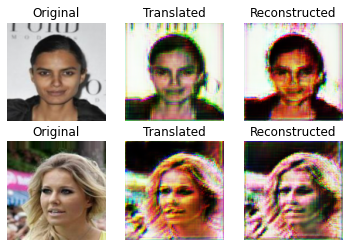





Train 0 / 2:   0%|          | 18/14989 [01:34<18:24:47,  4.43s/it]

Epoch 1/1
2/2 [==============================] - 0s 8ms/step - loss: 0.2027 - accuracy: 0.7812
Epoch 1/1
2/2 [==============================] - 0s 8ms/step - loss: 0.4935 - accuracy: 0.4219
Epoch 1/1
2/2 [==============================] - 0s 8ms/step - loss: 1.1048 - accuracy: 0.2031
Epoch 1/1
2/2 [==============================] - 0s 8ms/step - loss: 3.6411 - accuracy: 0.0781
Epoch 1/1
2/2 [==============================] - 0s 82ms/step - loss: 18.2406 - model_38_loss: 0.1106 - model_39_loss: 8.6601 - model_41_loss: 0.1972 - model_40_loss: 0.2661
Epoch: 0 with batch: 18


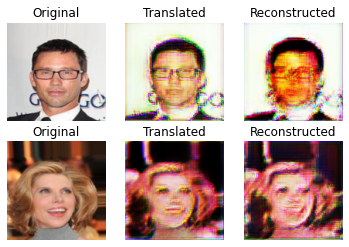

KeyboardInterrupt: ignored

In [36]:
project_path = '/content/drive/My Drive/hairy_gan'
gan = HairyGan()
gan.train(epochs=100, batch_size=64, sample_interval=100)

In [23]:
gan.g_AB = load_model('/content/drive/My Drive/hairy_gan/g_AB.hdf5', custom_objects={'InstanceNormalization': InstanceNormalization})
gan.g_BA = load_model('/content/drive/My Drive/hairy_gan/g_BA.hdf5', custom_objects={'InstanceNormalization': InstanceNormalization})

/usr/local/lib/python3.6/dist-packages/keras/engine/saving.py:341: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:65: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:21: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.


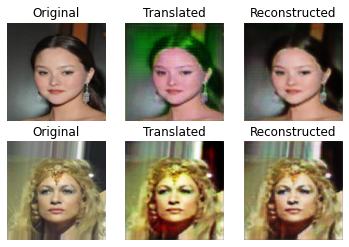

In [30]:
gan.sample_images()